In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import data_catalog
import tseries_mod
import esmlab_wrap

In [2]:
data_catalog.set_catalog('experiments')

active catalog: experiments


In [3]:
varnames = ['NBP']

In [4]:
experiment = 'historical'
ds_expr = tseries_mod.tseries_get_vars(varnames, 'lnd', experiment)
print(ds_expr)
ds_expr_ann = esmlab_wrap.compute_ann_mean(ds_expr)
print(ds_expr_ann)

<xarray.Dataset>
Dimensions:      (ensemble: 11, hist_interval: 2, region: 5, time: 1980)
Coordinates:
  * region       (region) object 'Global' 'SH_mid_lat' ... 'NH_mid_lat'
  * time         (time) object 1850-01-16 11:44:59 ... 2014-12-16 12:00:00
Dimensions without coordinates: ensemble, hist_interval
Data variables:
    time_bounds  (time, hist_interval) object 1849-12-31 23:30:00 ... 2015-01-01 00:00:00
    NBP          (time, region, ensemble) float32 -3.8983603 ... -9.469213
Attributes:
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created by /glade/work/klindsa...
    source:                                    Community Land Model CLM4.0
    hostname:                                  cheyenne
    username:                                  cmip6
    version:             

In [5]:
# load Dataset for corresponding experiment_ctrl
experiment_ctrl = data_catalog.find_in_index(experiment=experiment).ctrl_experiment.unique()[0]
print(experiment_ctrl)
ds_ctrl = tseries_mod.tseries_get_vars(varnames, 'lnd', experiment_ctrl)
print(ds_ctrl)
ds_ctrl_ann = esmlab_wrap.compute_ann_mean(ds_ctrl)
print(ds_ctrl_ann)

piControl
<xarray.Dataset>
Dimensions:      (hist_interval: 2, region: 5, time: 14400)
Coordinates:
  * time         (time) object 0001-01-16 11:44:59 ... 1200-12-16 12:00:00
  * region       (region) object 'Global' 'SH_mid_lat' ... 'NH_mid_lat'
Dimensions without coordinates: hist_interval
Data variables:
    NBP          (time, region) float32 -3.6829157 0.19838294 ... -5.4388366
    time_bounds  (time, hist_interval) object 0000-12-31 23:30:00 ... 1201-01-01 00:00:00
Attributes:
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created by /glade/work/klindsa...
    source:                                    Community Land Model CLM4.0
    hostname:                                  cheyenne
    username:                                  cmip6
    version:                        

In [6]:
# construct year range of experiment_ctrl to use for detrending
branch_years = data_catalog.find_in_index(experiment=experiment).ctrl_branch_year.unique()
yr_lo = branch_years.min() - 50
yyyymmdd_lo = str(int(yr_lo)).zfill(4)+'-01-01'
yr_hi = branch_years.max() + 50 + len(ds_expr_ann.time)
yyyymmdd_hi = str(int(yr_hi)).zfill(4)+'-01-01'
print((yyyymmdd_lo, yyyymmdd_hi))

('0451-01-01', '1086-01-01')


In [7]:
# compute experiment_ctrl mean, for detrending
ds_ctrl_ann_slice_mean = ds_ctrl_ann.sel(time=slice(yyyymmdd_lo, yyyymmdd_hi)).mean(dim='time')
print(ds_ctrl_ann_slice_mean)

<xarray.Dataset>
Dimensions:  (region: 5)
Coordinates:
  * region   (region) object 'Global' 'SH_mid_lat' ... 'NH_low_lat' 'NH_mid_lat'
Data variables:
    NBP      (region) float64 -0.02438 -0.001103 -0.005353 -0.004909 -0.01301
Attributes:
    history:  \n2019-10-28 16:52:37.887096 esmlab.resample(<DATASET>, freq="a...


In [8]:
ds_expr_ann_detrended = ds_expr_ann - ds_ctrl_ann_slice_mean

In [9]:
# add cummulate flux vars to datasets
# for ds in [ds_expr_ann, ds_expr_ann_detrended]:
for ds in [ds_expr_ann, ds_expr_ann_detrended]:
    for varname in varnames:
        da = ds[varname].cumsum(dim='time', keep_attrs=True)
        da.name = varname+'_CUM'
        da.attrs['units'] = 'Pg'
        ds[da.name] = da

print(ds_expr_ann)
# print(ds_expr_ann_detrended)

<xarray.Dataset>
Dimensions:      (ensemble: 11, hist_interval: 2, region: 5, time: 165)
Coordinates:
  * region       (region) object 'Global' 'SH_mid_lat' ... 'NH_mid_lat'
  * time         (time) object 1850-07-01 16:58:45 ... 2014-07-01 17:00:00
Dimensions without coordinates: ensemble, hist_interval
Data variables:
    time_bounds  (hist_interval, time) object 1849-12-31 23:30:00 ... 2015-01-01 00:00:00
    NBP          (time, region, ensemble) float64 -0.7473 -0.1117 ... 1.4 1.253
    NBP_CUM      (time, region, ensemble) float64 -0.7473 -0.1117 ... 14.7 17.19
Attributes:
    history:  \n2019-10-28 16:50:15.583941 esmlab.resample(<DATASET>, freq="a...


array([1.58620485, 0.30143382, 0.70169193, 1.53928245, 0.77821618,
       0.53285692, 2.36048561, 0.89829768, 1.44779706, 1.25607593,
       1.63512197])

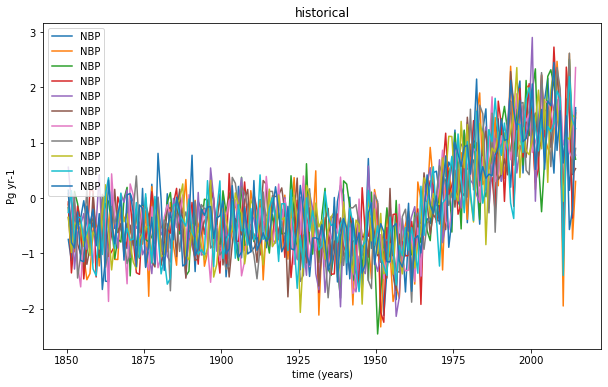

In [10]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['NBP'], title=experiment, region_val='Global')
ds_expr_ann['NBP'].sel(region='Global').isel(time=-1).values

array([-32.62545832, -35.63694188, -30.78564703, -34.65422191,
       -34.61228926, -34.35538197, -28.81640109, -30.56615857,
       -30.69758202, -33.11323629, -29.17753251])

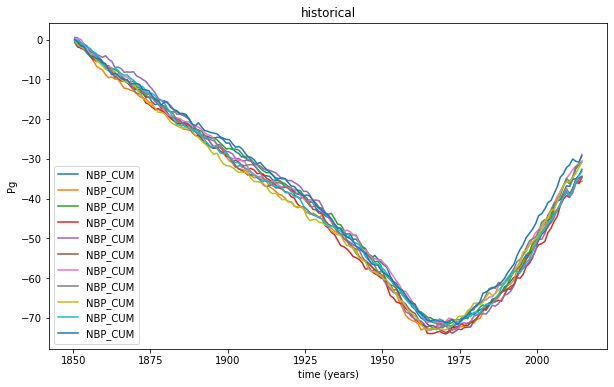

In [11]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['NBP_CUM'], title=experiment, region_val='Global')
ds_expr_ann['NBP_CUM'].sel(region='Global').isel(time=-1).values

array([-28.60318733, -31.61467089, -26.76337603, -30.63195091,
       -30.59001827, -30.33311098, -24.7941301 , -26.54388758,
       -26.67531102, -29.0909653 , -25.15526152])

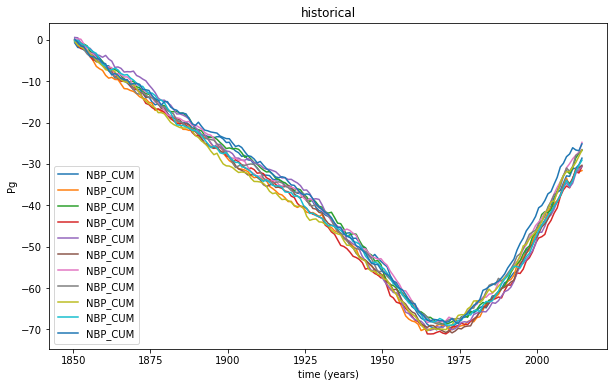

In [12]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['NBP_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['NBP_CUM'].sel(region='Global').isel(time=-1).values